In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from tslearn.clustering import TimeSeriesKMeans

/Users/alexbruefach/opt/anaconda3/envs/ds4aw/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
fp_p = '/Users/alexbruefach/Documents/GitHub/DSproject-covid-stress-impact/covid-policy-region/OxCGRT_latest.csv'
data_p = pd.read_csv(fp_p)

/Users/alexbruefach/opt/anaconda3/envs/ds4aw/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Policy Data Cleaning and Clustering

In [3]:
data_p = data_p[data_p['CountryCode']=='USA']
data_p = data_p.dropna(subset=['RegionName'])
data_p['Datetime'] = pd.to_datetime(data_p['Date'], format='%Y%m%d')
data_p = data_p[(data_p['Datetime']<pd.Timestamp(2021,6,1)) & (data_p['Datetime']>pd.Timestamp(2020,12,1))]

In [4]:
data_vacpol_usa = data_p[['RegionName', 'H7_Vaccination policy', 'Datetime']]

In [5]:
df_states = data_vacpol_usa.pivot(index='RegionName', columns='Datetime')['H7_Vaccination policy']
df_states = df_states.dropna(axis='columns')

In [6]:
states = data_p['RegionName'].unique()

In [7]:
from scipy.spatial import distance_matrix
df = df_states
X = pd.DataFrame(distance_matrix(df.values, df.values, p=1), 
                 index=df.index, columns=df.index)

In [8]:
n_clusters = 4
gmm = GaussianMixture(n_components = n_clusters, covariance_type = 'full')
gmm_labels =gmm.fit_predict(X)

dict_stategroups = dict(zip(states,gmm_labels))
state_groups = [list(df_states.index[gmm_labels == i]) for i in range(n_clusters)]

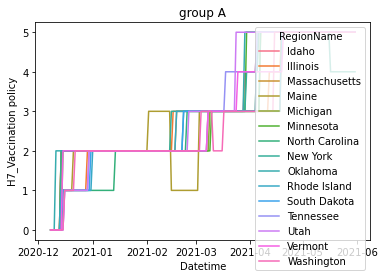

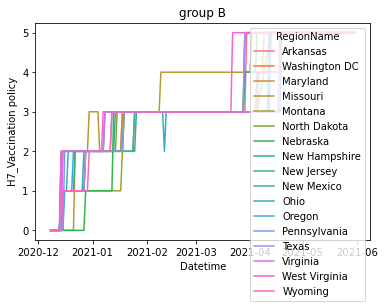

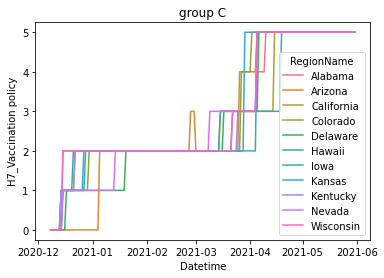

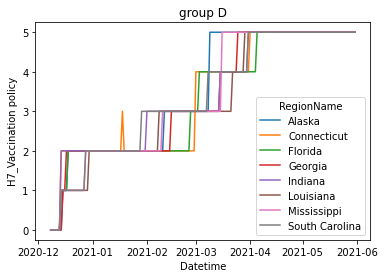

In [9]:
for i in range(n_clusters):
    data_onereg = data_p[data_p['RegionName'].isin(state_groups[i])]
    sns.lineplot(data=data_onereg, x='Datetime', y='H7_Vaccination policy', hue="RegionName")
    plt.title('group '+chr(i+65))
    plt.show()

## Stress dataset

In [10]:
fp_s = '/Users/alexbruefach/Documents/GitHub/DSproject-covid-stress-impact/covid19tracker_recoded.csv'
data_s = pd.read_csv(fp_s, encoding='latin-1')

/Users/alexbruefach/opt/anaconda3/envs/ds4aw/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (390,391,392,393,394,395,405,406) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
data_s['month'] = pd.DatetimeIndex(data_s.endtime).month
data_s['year'] = pd.DatetimeIndex(data_s.endtime).year
data_s['year-month'] = pd.to_datetime(data_s[['year', 'month']].assign(DAY=1))

In [12]:
data_s.keys()

Index(['ï..RecordNo', 'endtime', 'state', 'qweek', 'i1_health', 'i2_health',
       'i7a_health', 'i3_health', 'i4_health', 'i5_health_1',
       ...
       'child_education_3', 'child_education_4', 'childvac', 'combi_vac',
       'employment_status.cat', 'PHQ4_sum', 'child_education_sum', 'month',
       'year', 'year-month'],
      dtype='object', length=413)

In [13]:
states_dict = {'Alabama': 1, 'Alaska': 0, 'Arizona': 3, 'Arkansas': 2, 
               'California': 1, 'Colorado': 3, 'Connecticut': 0, 'Delaware': 3, 
               'Florida': 0, 'Georgia': 0, 'Hawaii': 1, 'Idaho': 1, 'Illinois': 1, 
               'Indiana': 0, 'Iowa': 3, 'Kansas': 3, 'Kentucky': 1, 'Louisiana': 0, 
               'Maine': 1, 'Maryland': 2, 'Massachusetts': 1, 'Michigan': 1, 'Minnesota': 1, 
               'Mississippi': 0, 'Missouri': 0, 'Montana': 2, 'Nebraska': 2, 'Nevada': 1, 
               'New Hampshire': 2, 'New Jersey': 2, 'New Mexico': 2, 'New York': 1, 
               'North Carolina': 1, 'North Dakota': 2, 'Ohio': 2, 'Oklahoma': 1, 'Oregon': 2, 
               'Pennsylvania': 2, 'Rhode Island': 1, 'South Carolina': 0, 'South Dakota': 1, 
               'Tennessee': 1, 'Texas': 2, 'Utah': 1, 'Vermont': 1, 'Virginia': 2, 'Washington': 1, 
               'District of Columbia': 2, 'West Virginia': 2, 'Wisconsin': 1, 'Wyoming': 2}

In [14]:
data_state_list = data_s['state'].tolist()
state_labels = [states_dict[i] for i in data_state_list]

In [15]:
data_s['state_labels'] = state_labels

## Exploratory Data Analysis

In [16]:
data_stress_additive = data_s[['state_labels', 'PHQ4_sum']]

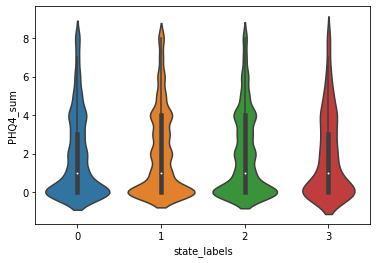

In [35]:
sns.violinplot(x = 'state_labels', y = 'PHQ4_sum', data = data_s)
plt.show()

In [23]:
## Group by dates
data_s_pre = data_s[(data_s['year-month']<pd.Timestamp(2020,11,30))]
data_s_dur = data_s[(data_s['year-month']<pd.Timestamp(2021,4,30)) & (data_s['year-month']>pd.Timestamp(2020,12,31))]
data_s_pos = data_s[(data_s['year-month']>pd.Timestamp(2021,4,30))]

In [30]:
data_s_pre.groupby('state_labels')['PHQ4_sum'].value_counts()

state_labels  PHQ4_sum
0             0.0          665
              1.0          219
              2.0          210
              4.0          192
              3.0          148
              5.0           91
              6.0           54
              8.0           44
              7.0           29
1             0.0         1368
              4.0          531
              2.0          471
              1.0          447
              3.0          389
              5.0          223
              6.0          153
              8.0          113
              7.0           80
2             0.0          961
              4.0          324
              2.0          322
              1.0          284
              3.0          215
              5.0          134
              6.0          100
              8.0           58
              7.0           47
3             0.0          193
              1.0           70
              2.0           62
              4.0           60
              3.

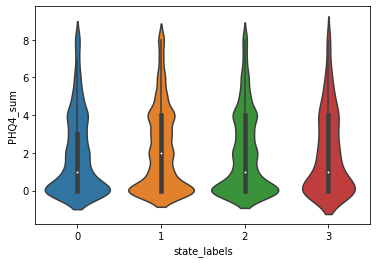

In [31]:
sns.violinplot(x = 'state_labels', y = 'PHQ4_sum', data = data_s_pre)
plt.show()

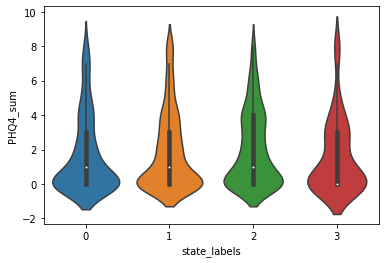

In [33]:
sns.violinplot(x = 'state_labels', y = 'PHQ4_sum', data = data_s_dur)
plt.show()

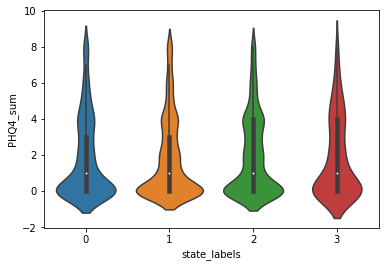

In [34]:
sns.violinplot(x = 'state_labels', y = 'PHQ4_sum', data = data_s_pos)
plt.show()